In [1]:
import sys
sys.path.append('../')
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import face_recognition
from matplotlib.pyplot import imshow
from src.metrics import intersection_over_union as iou, area_ratio
import seaborn as sns
sns.set()
%matplotlib inline

Define row functions:

In [2]:
def row_iou(row):
    res = iou((row['x_1_true'], row['y_1_true'], row['width_true'], row['height_true']),
              (row['x_1_pred'], row['y_1_pred'], row['width_pred'], row['height_pred']))
    return res

def row_area_ratio(row):
    ratio = area_ratio((row['x_1_true'], row['y_1_true'], row['width_true'], row['height_true']),
                       (row['x_1_pred'], row['y_1_pred'], row['width_pred'], row['height_pred']))
    return ratio

Read the data frames:

In [3]:
true_boxes = pd.read_table('../annotations/list_bbox_celeba.txt', delim_whitespace=True)
with open('../data/hog_bounding_boxes_dict.pkl', 'rb') as f:
    predicted_boxes = pd.DataFrame(pickle.load(f))

Merge data frames and calculate values:

In [4]:
merged_boxes = true_boxes.merge(predicted_boxes, on='image_id', suffixes=('_true', '_pred'))
merged_boxes['iou'] = merged_boxes.apply(lambda row: row_iou(row), axis=1)
merged_boxes['area_ratio'] = merged_boxes.apply(lambda row: row_area_ratio(row), axis=1)

### Multiple faces analysis

In some cases more than only 1 face was detected. I considered the biggest one as the target one.

In [6]:
with open('../data/teksty.txt', 'r') as f:
    texts = f.readlines()[1:]

In [7]:
print(f'More than 1 faces was found on {len(texts)} images.')

More than 1 faces was found on 1482 images.


In [8]:
image_ids = [text.split(' ')[2] for text in texts]
num_faces = [int(text.split(' ')[4]) for text in texts]
more_faces = pd.DataFrame({'image_id': image_ids, 'number_faces': num_faces})

In [9]:
more_faces.number_faces.value_counts()

2    1333
3     106
4      29
5       6
6       4
7       3
9       1
Name: number_faces, dtype: int64

In [10]:
more_faces.loc[more_faces.number_faces >= 6]

image_id  number_faces
102   013970.jpg             6
143   018910.jpg             7
254   034193.jpg             6
453   061254.jpg             9
494   067463.jpg             7
615   085029.jpg             7
1233  171711.jpg             6
1236  172512.jpg             6

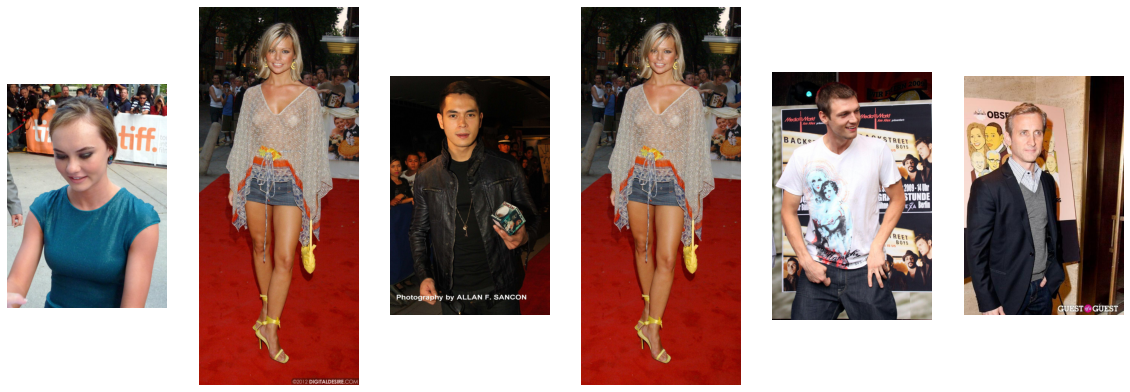

In [11]:
paths = ["../images/061254.jpg", "../images/067463.jpg", "../images/085029.jpg",
         "../images/018910.jpg", "../images/013970.jpg", "../images/172512.jpg"]
fig, axs = plt.subplots(1, 6, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    ax.imshow(image)
    ax.axis('off')

### IoU analysis

In [12]:
merged_boxes

image_id  x_1_true  y_1_true  width_true  height_true  x_1_pred  \
0      000001.jpg        95        71         226          313       118   
1      000002.jpg        72        94         221          306        68   
2      000003.jpg       216        59          91          126         0   
3      000004.jpg       622       257         564          781         0   
4      000006.jpg       146        67         182          252       150   
...           ...       ...       ...         ...          ...       ...   
70877  202592.jpg       409       108         107          148       414   
70878  202594.jpg       108       127         244          338       139   
70879  202595.jpg      1381        91         221          306      1398   
70880  202596.jpg       137       129         114          158       139   
70881  202598.jpg       195        28          91          126       195   

       y_1_pred  width_pred  height_pred       iou  area_ratio  
0           118         186          186  0.489072    0.489072  
1           118         223          223  0.712762    0.735353  
2             0           0            0       NaN         NaN  
3             0           0            0       NaN         NaN  
4           116         154          154  0.517094    0.517094  
...         ...         ...          ...       ...         ...  
70877       128         107          107  0.666667    0.722973  
70878       201         185          186  0.417233    0.417233  
70879       160         185          185  0.506092    0.506092  
70880       163         108          108  0.647568    0.647568  
70881        46          90           90  0.706436    0.706436  

[70882 rows x 11 columns]

[Text(0.5, 0, 'Area Ratio'), Text(0, 0.5, 'Intersection over Union')]

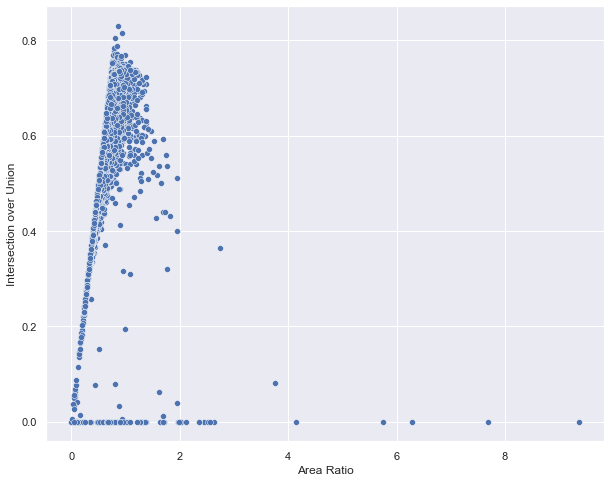

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
relation_plot = sns.scatterplot(data=merged_boxes, x="area_ratio", y="iou", ax=ax)
relation_plot.set(xlabel='Area Ratio', ylabel='Intersection over Union')

Why is that so? Area ratio almost 10?

In [14]:
merged_boxes.loc[merged_boxes.iou == 0]

image_id  x_1_true  y_1_true  width_true  height_true  x_1_pred  \
1510   004282.jpg      1938       231         278          385       280   
1617   004592.jpg       110        59         133          184        43   
2119   006173.jpg       252        54         166          230        77   
3087   008909.jpg       495       100         166          230       407   
3567   010306.jpg       123        51         109          151         8   
...           ...       ...       ...         ...          ...       ...   
67481  193820.jpg         6        12          55           76        87   
68801  197200.jpg       339        56          73          101       506   
68905  197461.jpg        77       123         263          364       170   
70354  201268.jpg       640        94         112          155        55   
70763  202311.jpg       127        58         231          320        43   

       y_1_pred  width_pred  height_pred  iou  area_ratio  
1510        280         666          666  0.0    4.144221  
1617        415         223          223  0.0    2.032077  
2119        511         185          185  0.0    0.896412  
3087        387         186          186  0.0    0.906129  
3567        343         107          107  0.0    0.695607  
...         ...         ...          ...  ...         ...  
67481       267          60           62  0.0    0.889952  
68801       425          43           42  0.0    0.244948  
68905        46          62           62  0.0    0.040154  
70354       104         108          107  0.0    0.665668  
70763       514         223          223  0.0    0.672741  

[96 rows x 11 columns]

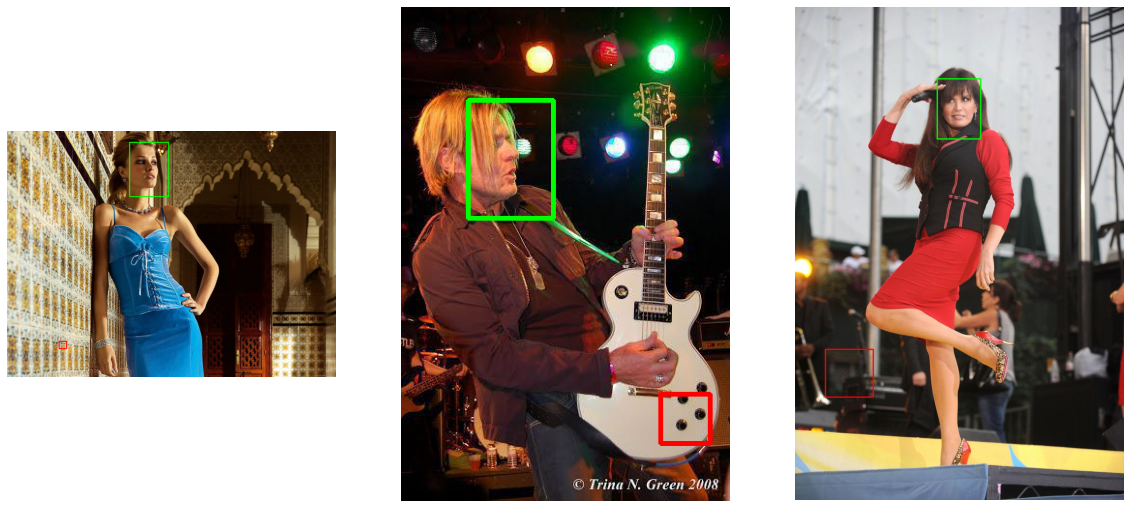

In [16]:
paths = ["../images/017545.jpg", "../images/092144.jpg", "../images/134254.jpg"]
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    box = merged_boxes.loc[merged_boxes.image_id == paths[i].split('/')[-1]]
    x1_pred, y1_pred, width_pred, height_pred = int(box.x_1_pred), int(box.y_1_pred), int(box.width_pred), int(box.height_pred)
    image = cv2.rectangle(image, (x1_pred, y1_pred + height_pred), (x1_pred + width_pred, y1_pred), (255, 0, 0), 3)
    x1_true, y1_true, width_true, height_true = int(box.x_1_true), int(box.y_1_true), int(box.width_true), int(box.height_true)
    image = cv2.rectangle(image, (x1_true, y1_true + height_true), (x1_true + width_true, y1_true), (0, 255, 0), 3)
    ax.imshow(image)
    ax.axis('off')

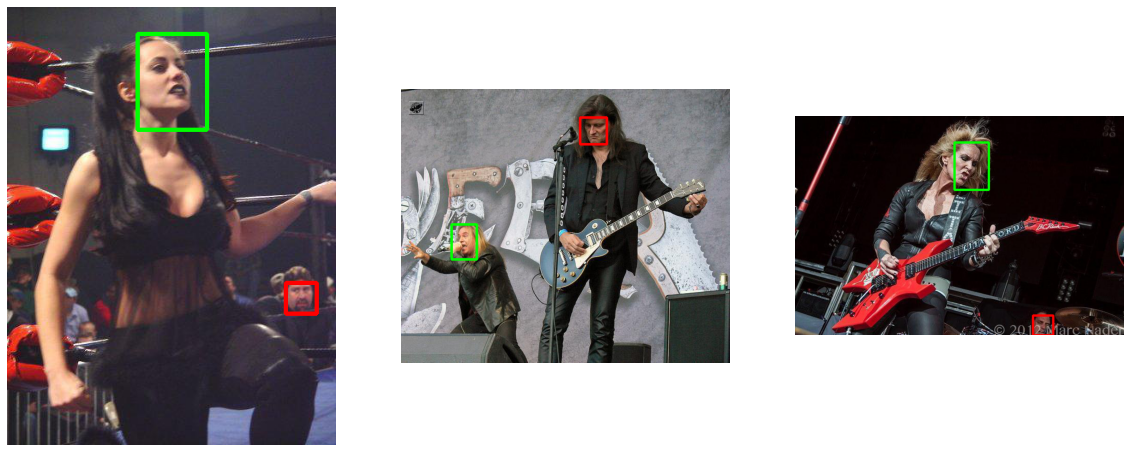

In [15]:
paths = ["../images/141383.jpg", "../images/156288.jpg", "../images/197200.jpg"]
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    box = merged_boxes.loc[merged_boxes.image_id == paths[i].split('/')[-1]]
    x1_pred, y1_pred, width_pred, height_pred = int(box.x_1_pred), int(box.y_1_pred), int(box.width_pred), int(box.height_pred)
    image = cv2.rectangle(image, (x1_pred, y1_pred + height_pred), (x1_pred + width_pred, y1_pred), (255, 0, 0), 3)
    x1_true, y1_true, width_true, height_true = int(box.x_1_true), int(box.y_1_true), int(box.width_true), int(box.height_true)
    image = cv2.rectangle(image, (x1_true, y1_true + height_true), (x1_true + width_true, y1_true), (0, 255, 0), 3)
    ax.imshow(image)
    ax.axis('off')

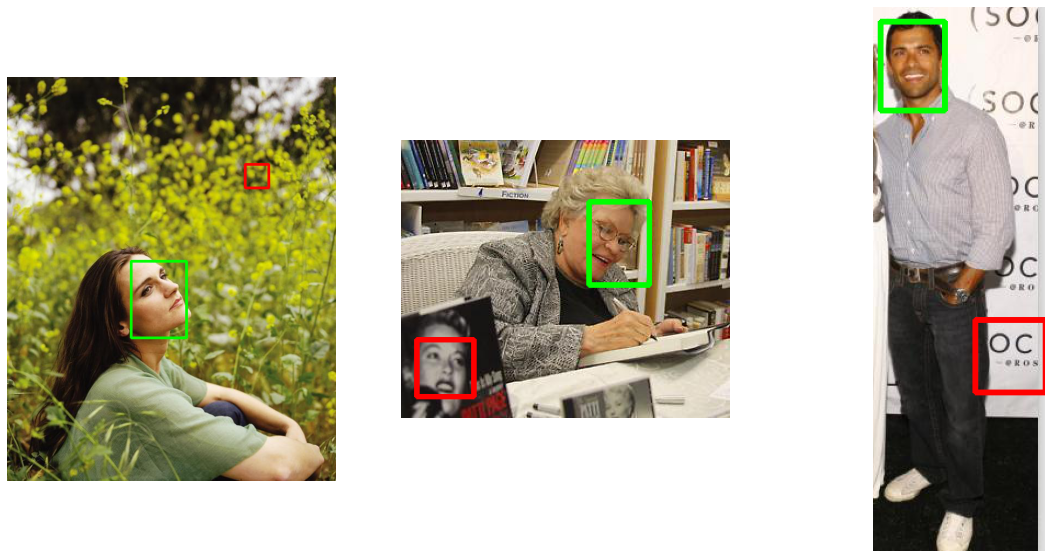

In [20]:
paths = ["../images/028985.jpg", "../images/061423.jpg", "../images/193820.jpg"]
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    box = merged_boxes.loc[merged_boxes.image_id == paths[i].split('/')[-1]]
    x1_pred, y1_pred, width_pred, height_pred = int(box.x_1_pred), int(box.y_1_pred), int(box.width_pred), int(box.height_pred)
    image = cv2.rectangle(image, (x1_pred, y1_pred + height_pred), (x1_pred + width_pred, y1_pred), (255, 0, 0), 3)
    x1_true, y1_true, width_true, height_true = int(box.x_1_true), int(box.y_1_true), int(box.width_true), int(box.height_true)
    image = cv2.rectangle(image, (x1_true, y1_true + height_true), (x1_true + width_true, y1_true), (0, 255, 0), 3)
    ax.imshow(image)
    ax.axis('off')

In [28]:
merged_boxes.loc[merged_boxes.area_ratio > 3]

image_id  x_1_true  y_1_true  width_true  height_true  x_1_pred  \
1510   004282.jpg      1938       231         278          385       280   
8652   024932.jpg       166        38          57           79       221   
24773  071489.jpg       223       326         169          234       332   
33185  095800.jpg       523        87         107          148        76   
47637  137279.jpg       185        51          62           86       221   
56811  163954.jpg       194        44          55           76        12   

       y_1_pred  width_pred  height_pred       iou  area_ratio  
1510        280         666          666  0.000000    4.144221  
8652        304         186          186  0.000000    7.682878  
24773       290         386          385  0.080636    3.757902  
33185       247         385          385  0.000000    9.360003  
47637       242         180          186  0.000000    6.279070  
56811       167         155          155  0.000000    5.747608

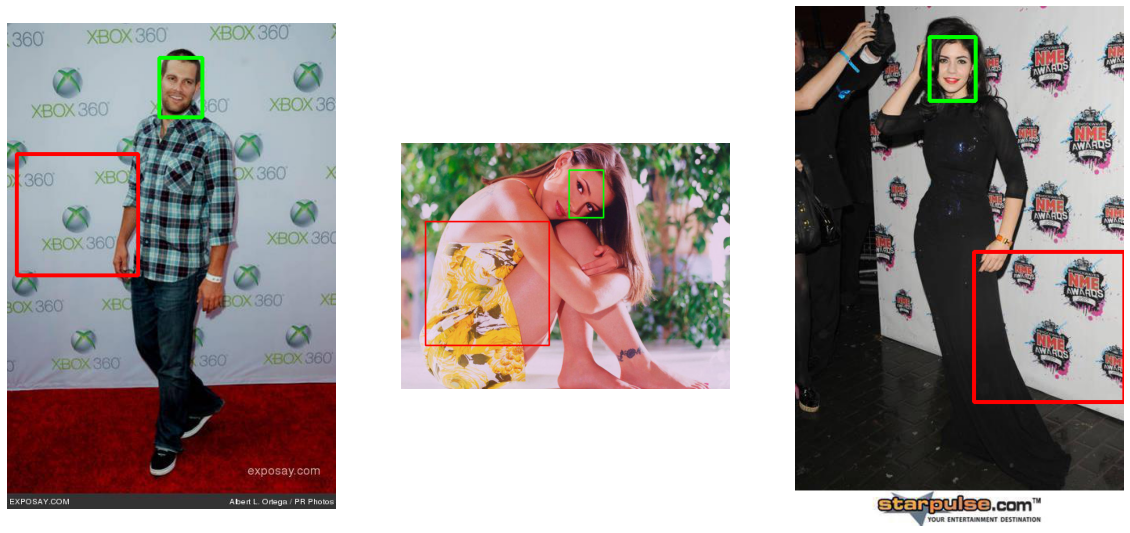

In [19]:
paths = ["../images/163954.jpg", "../images/095800.jpg", "../images/024932.jpg"]
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    box = merged_boxes.loc[merged_boxes.image_id == paths[i].split('/')[-1]]
    x1_pred, y1_pred, width_pred, height_pred = int(box.x_1_pred), int(box.y_1_pred), int(box.width_pred), int(box.height_pred)
    image = cv2.rectangle(image, (x1_pred, y1_pred + height_pred), (x1_pred + width_pred, y1_pred), (255, 0, 0), 3)
    x1_true, y1_true, width_true, height_true = int(box.x_1_true), int(box.y_1_true), int(box.width_true), int(box.height_true)
    image = cv2.rectangle(image, (x1_true, y1_true + height_true), (x1_true + width_true, y1_true), (0, 255, 0), 3)
    ax.imshow(image)
    ax.axis('off')

In [29]:
merged_boxes.loc[merged_boxes.area_ratio < 3].sort_values(by='area_ratio', ascending=False).head()

image_id  x_1_true  y_1_true  width_true  height_true  x_1_pred  \
6592   018964.jpg       227        81          55           76       187   
11279  032310.jpg       796       140         291          403       726   
61228  177229.jpg       160        53          99          137       118   
22398  064387.jpg       147        48         143          198       111   
9965   028631.jpg       113        26          70           97        67   

       y_1_pred  width_pred  height_pred       iou  area_ratio  
6592         80         107          107  0.365097    2.738995  
11279       726         555          555  0.000000    2.626564  
61228       263         186          186  0.000000    2.550763  
22398       350         268          267  0.000000    2.527230  
9965        139         129          129  0.000000    2.450810

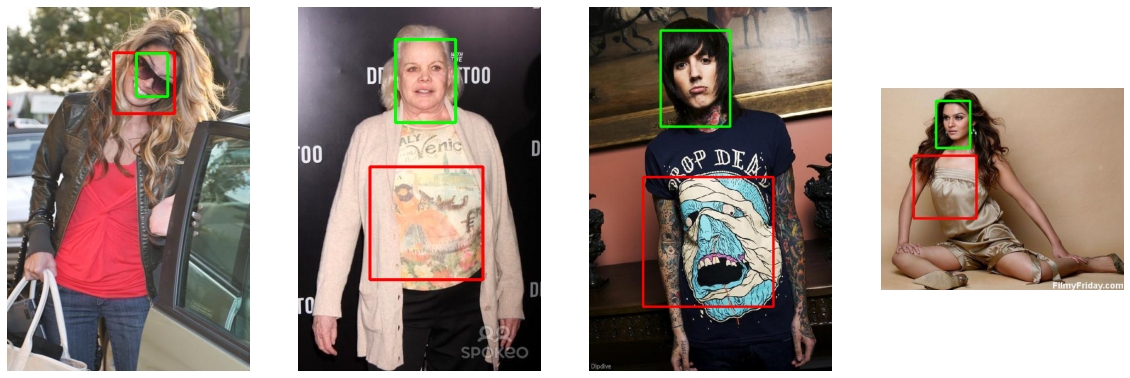

In [32]:
paths = ["../images/018964.jpg", "../images/177229.jpg",  "../images/064387.jpg",  "../images/028631.jpg"]
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axs):
    image = face_recognition.load_image_file(paths[i])
    box = merged_boxes.loc[merged_boxes.image_id == paths[i].split('/')[-1]]
    x1_pred, y1_pred, width_pred, height_pred = int(box.x_1_pred), int(box.y_1_pred), int(box.width_pred), int(box.height_pred)
    image = cv2.rectangle(image, (x1_pred, y1_pred + height_pred), (x1_pred + width_pred, y1_pred), (255, 0, 0), 3)
    x1_true, y1_true, width_true, height_true = int(box.x_1_true), int(box.y_1_true), int(box.width_true), int(box.height_true)
    image = cv2.rectangle(image, (x1_true, y1_true + height_true), (x1_true + width_true, y1_true), (0, 255, 0), 3)
    ax.imshow(image)
    ax.axis('off')

How to find the prue and false positives??

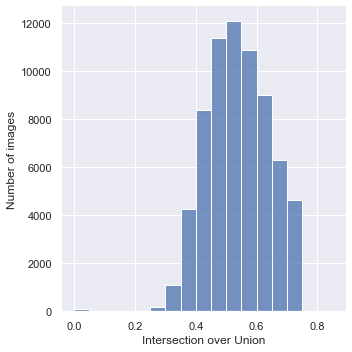

In [35]:
iou_distribution = sns.displot(merged_boxes, x="iou", binwidth=0.05)
iou_distribution.set(xlabel='Intersection over Union', ylabel='Number of images')

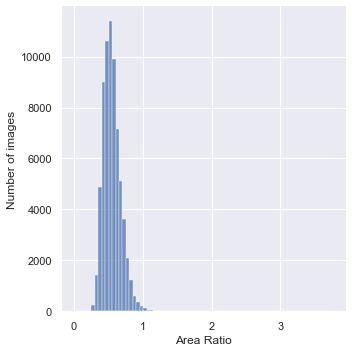

In [37]:
area_ratio_dist = sns.displot(merged_boxes.loc[merged_boxes.iou > 0], x="area_ratio", binwidth=0.05)
area_ratio_dist.set(xlabel='Area Ratio', ylabel='Number of images')

### Filter detections

In [5]:
total_faces = len(merged_boxes.index)
faces_not_found = merged_boxes.iou.isna().sum() + (merged_boxes.iou == 0).sum()
print(f"Total number of faces: {total_faces}, faces not found: {faces_not_found}, "
      f"detection ratio: {100 - round(100 * faces_not_found / total_faces, 2)}%.")

Total number of faces: 70882, faces not found: 2647, detection ratio: 96.27%.


In [39]:
good_boxes = merged_boxes.dropna()
good_boxes = good_boxes.loc[good_boxes.iou > 0]
good_boxes

image_id  x_1_true  y_1_true  width_true  height_true  x_1_pred  \
0      000001.jpg        95        71         226          313       118   
1      000002.jpg        72        94         221          306        68   
4      000006.jpg       146        67         182          252       150   
5      000007.jpg        64        93         211          292        77   
6      000008.jpg       212        89         218          302       236   
...           ...       ...       ...         ...          ...       ...   
70877  202592.jpg       409       108         107          148       414   
70878  202594.jpg       108       127         244          338       139   
70879  202595.jpg      1381        91         221          306      1398   
70880  202596.jpg       137       129         114          158       139   
70881  202598.jpg       195        28          91          126       195   

       y_1_pred  width_pred  height_pred       iou  area_ratio  
0           118         186          186  0.489072    0.489072  
1           118         223          223  0.712762    0.735353  
4           116         154          154  0.517094    0.517094  
5           139         185          186  0.558495    0.558495  
6           167         154          155  0.362568    0.362568  
...         ...         ...          ...       ...         ...  
70877       128         107          107  0.666667    0.722973  
70878       201         185          186  0.417233    0.417233  
70879       160         185          185  0.506092    0.506092  
70880       163         108          108  0.647568    0.647568  
70881        46          90           90  0.706436    0.706436  

[68235 rows x 11 columns]

<AxesSubplot:>

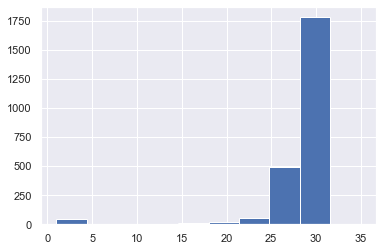

In [40]:
identities = pd.read_table('../annotations/identity_CelebA.txt', delim_whitespace=True)
good_boxes = good_boxes.merge(identities, on='image_id')
good_boxes.identity.value_counts().hist(bins=10)

In [42]:
good_image_ids = good_boxes.image_id.tolist()
with open('../data/good_image_ids_list.pkl', 'wb') as f:
    pickle.dump(good_image_ids, f)